# Data Science Final Project: Poster Object Detection
## Group Members: Jiacheng Shi, Boyuan Sun, Xiangru

** Notebook Introduction: **

This notebook documents the methodology with the help of YOLO. We first explore two types of object representation into vectorization and use this vectorization as our training data. 

1. detected objects vectorization : we record the number of objects detected by YOLO and add 1 to the corresponding idec
2. object confidence vectorization : we record the probability of objects detected by YOLO and add this confidence level in to the corresponding index

We then concatenate these vectors with bag of words and train a fully-connected neural network and evaluate the results.

## Library Used

In [64]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import string
import ast
import re
import warnings
from meter import score, score_thres
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
warnings.filterwarnings('ignore')
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, LSTM, Dropout, RNN
from keras.models import Model, Sequential
from keras.optimizers import SGD, RMSprop, Adam

## Data Preprocessing

In [75]:
# read in data
imdb_movie = pd.read_csv('data/imdb_multilabel.csv')

# drop movies with unknown plot
imdb_movie['plot'] = imdb_movie['plot'].apply(lambda sentence: 'drop' if (('plot ' in sentence.lower()) 
                                              and ('unknown' in sentence.lower()))
                                              or (len(sentence.split()) < 100) 
                                              else sentence.lower())
imdb_movie = imdb_movie[imdb_movie['plot'] != 'drop']

# single-label encoding
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

# multi-label encoded as an array
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros(20)
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return list(encode)

imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].apply(multi_label_encoder)
imdb_movie['plot_list'] = imdb_movie['plot_list'].apply(ast.literal_eval)

# train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_movie[['plot','imdb_id']], 
                                                    imdb_movie['all_genre_encode'],
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    stratify = imdb_movie['genre']
                                                    )

# reshape y_train and y_test
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [76]:
# imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].values.apply(multi_label_encoder)
all_genre_encode = np.zeros((len(imdb_movie['all_genre_encode']), 20))
for idx, val in enumerate(imdb_movie['all_genre_encode'].values):
    all_genre_encode[idx] = val
all_genre_encode

array([[1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Preprocessing the Poster Images

#### dictionary that keeps track of the poster genre index

In [22]:
poster_index = dict(zip(imdb_movie.imdb_id.values, range(len(imdb_movie.imdb_id.values))))

### YOLO Object Detection

In [2]:
import cv2
from darkflow.net.build import TFNet
from sys import exit

In [3]:
options = {"load":"/Users/jerrysun/Github/darkflow/bin/yolo.weights", 
           "model":"/Users/jerrysun/Github/darkflow/cfg/yolo.cfg",
           "threshold": 0.1}
#options = {"model": "cfg/yolo.cfg", "load": "bin/yolo.weights", "threshold": 0.1}
tfnet = TFNet(options)

Parsing /Users/jerrysun/Github/darkflow/cfg/yolo.cfg
Loading /Users/jerrysun/Github/darkflow/bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.030317068099975586s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2            

In [28]:
import os
poster_names = os.listdir('posters')[1:]

In [30]:
poster_index = dict(zip(imdb_movie.imdb_id.values, range(len(imdb_movie.imdb_id.values))))

In [44]:
yolo_pred = {}
for poster_name in tqdm(poster_names):
    poster_id = poster_name.strip('.jpg')
    image = load_img('posters/' + poster_name)
    image = img_to_array(image)
    if len(image.shape) == 3:
        yolo_pred[poster_id] = tfnet.return_predict(image)

100%|██████████| 6254/6254 [1:46:35<00:00,  1.02s/it]


In [45]:
len(yolo_pred)

6254

In [48]:
#yolo_np = np.save('yolo_pred.npy', yolo_pred)

### Construct the feature vectors
79 Objects in the poster were detected by YOLO.

In [98]:
# Count the objects detected by YOLO
objects_detected = set()
for key, item in yolo_pred.items():
    for label_dict in item:
        objects_detected.add(label_dict['label'])

In [99]:
object_index = dict(zip(list(objects_detected), range(len(objects_detected))))

In [54]:
yolo_pred['tt3131050']

[{'bottomright': {'x': 1899, 'y': 2472},
  'confidence': 0.83158284,
  'label': 'person',
  'topleft': {'x': 0, 'y': 158}}]

### Train Set Object Vectorization

#### 1. detected objects vectorization

In [163]:
train_obj_vec = np.zeros((X_train.shape[0], 79))
for index, poster_id in enumerate(X_train.imdb_id.values):
    if poster_id in yolo_pred:
        list_obj_dict = yolo_pred[poster_id]
        for obj_dict in list_obj_dict:
            train_obj_vec[index, object_index[obj_dict['label']]] += 1

In [164]:
test_obj_vec = np.zeros((X_test.shape[0], 79))
for index, poster_id in enumerate(X_test.imdb_id.values):
    if poster_id in yolo_pred:
        list_obj_dict = yolo_pred[poster_id]
        for obj_dict in list_obj_dict:
            test_obj_vec[index, object_index[obj_dict['label']]] += 1

In [165]:
train_obj_vec.shape

(3489, 79)

In [166]:
test_obj_vec.shape

(873, 79)

**Fully-connected Layer**

In [167]:
model = Sequential()
model.add(Dense(512, input_dim = train_obj_vec.shape[1], activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               40960     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                5140      
Total params: 177,428
Trainable params: 177,428
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc'])

In [170]:
dense_history = model.fit(train_obj_vec, y_train,
                batch_size=128,
                epochs=50, validation_data = (test_obj_vec, y_test))

Train on 3489 samples, validate on 873 samples
Epoch 1/50
3489/3489 [==============================] - 1s 156us/step - loss: 0.5671 - acc: 0.7735 - val_loss: 0.4671 - val_acc: 0.8422
Epoch 2/50
3489/3489 [==============================] - 0s 43us/step - loss: 0.4612 - acc: 0.8370 - val_loss: 0.4373 - val_acc: 0.8431
Epoch 3/50
3489/3489 [==============================] - 0s 42us/step - loss: 0.4332 - acc: 0.8424 - val_loss: 0.4154 - val_acc: 0.8442
Epoch 4/50
3489/3489 [==============================] - 0s 42us/step - loss: 0.4110 - acc: 0.8447 - val_loss: 0.3985 - val_acc: 0.8442
Epoch 5/50
3489/3489 [==============================] - 0s 43us/step - loss: 0.3940 - acc: 0.8462 - val_loss: 0.3893 - val_acc: 0.8451
Epoch 6/50
3489/3489 [==============================] - 0s 42us/step - loss: 0.3836 - acc: 0.8473 - val_loss: 0.3848 - val_acc: 0.8455
Epoch 7/50
3489/3489 [==============================] - 0s 48us/step - loss: 0.3780 - acc: 0.8482 - val_loss: 0.3826 - val_acc: 0.8463
Epoch 8

This model with detected objects vectorization does not give accurate predictions so further evaluation is abandoned.

#### 2. Object confidence vectorization

In [138]:
train_obj_vec = np.zeros((X_train.shape[0], 79))
for index, poster_id in enumerate(X_train.imdb_id.values):
    if poster_id in yolo_pred:
        list_obj_dict = yolo_pred[poster_id]
        for obj_dict in list_obj_dict:
            train_obj_vec[index, object_index[obj_dict['label']]] += obj_dict['confidence']

In [139]:
test_obj_vec = np.zeros((X_test.shape[0], 79))
for index, poster_id in enumerate(X_test.imdb_id.values):
    if poster_id in yolo_pred:
        list_obj_dict = yolo_pred[poster_id]
        for obj_dict in list_obj_dict:
            test_obj_vec[index, object_index[obj_dict['label']]] += obj_dict['confidence']

**Fully-connected Layer**

In [140]:
model = Sequential()
model.add(Dense(512, input_dim = train_obj_vec.shape[1], activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))

In [142]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

dense_history = model.fit(train_obj_vec, y_train,
                batch_size=128,
                epochs=50, validation_data = (test_obj_vec, y_test))

Train on 3489 samples, validate on 873 samples
Epoch 1/50
3489/3489 [==============================] - 0s 143us/step - loss: 0.3524 - acc: 0.8565 - val_loss: 0.3806 - val_acc: 0.8447
Epoch 2/50
3489/3489 [==============================] - 0s 53us/step - loss: 0.3506 - acc: 0.8576 - val_loss: 0.3809 - val_acc: 0.8448
Epoch 3/50
3489/3489 [==============================] - 0s 48us/step - loss: 0.3502 - acc: 0.8580 - val_loss: 0.3800 - val_acc: 0.8448
Epoch 4/50
3489/3489 [==============================] - 0s 45us/step - loss: 0.3487 - acc: 0.8583 - val_loss: 0.3808 - val_acc: 0.8459
Epoch 5/50
3489/3489 [==============================] - 0s 68us/step - loss: 0.3479 - acc: 0.8581 - val_loss: 0.3818 - val_acc: 0.8455
Epoch 6/50
3489/3489 [==============================] - 0s 67us/step - loss: 0.3485 - acc: 0.8581 - val_loss: 0.3810 - val_acc: 0.8454
Epoch 7/50
3489/3489 [==============================] - 0s 48us/step - loss: 0.3472 - acc: 0.8578 - val_loss: 0.3812 - val_acc: 0.8443
Epoch 8

In [144]:
dense_train = model.predict(train_obj_vec)
dense_test = model.predict(test_obj_vec)

In [145]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_train, dense_train, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_train, dense_train, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_train, dense_train, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_train, dense_train, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_train, dense_train, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_train, dense_train, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.8765978790484379
Fully-connected Exact Accuracy on train : 0.09171682430495844
Fully-connected Precision on train : 0.8446919371188703
Fully-connected Recall on train : 0.23126702935505888
Fully-connected Hit Rate on train : 0.702493551160791
Fully-connected F1 score on train : 0.3631168122662505


In [146]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_test, dense_test, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_test, dense_test, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_test, dense_test, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_test, dense_test, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_test, dense_test, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_test, dense_test, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.8389461626575029
Fully-connected Exact Accuracy on train : 0.029782359679266894
Fully-connected Precision on train : 0.30417947605390855
Fully-connected Recall on train : 0.11908359073408085
Fully-connected Hit Rate on train : 0.572737686139748
Fully-connected F1 score on train : 0.17115967386899184


In [235]:
obj_metrics = metrics_thres_df(y_train, y_test, dense_train, dense_test)

### Stack Prediction : Bag Of Words + Poster Objects Vectorization

In [186]:
# read in data
imdb_movie = pd.read_csv('data/imdb_multilabel.csv')

# drop movies with unknown plot
imdb_movie['plot'] = imdb_movie['plot'].apply(lambda sentence: 'drop' if (('plot ' in sentence.lower()) 
                                              and ('unknown' in sentence.lower()))
                                              or (len(sentence.split()) < 100) 
                                              else sentence.lower())
imdb_movie = imdb_movie[imdb_movie['plot'] != 'drop']

# single-label encoding
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

# multi-label encoded as an array
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros(20)
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return list(encode)

imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].apply(multi_label_encoder)
imdb_movie['plot_list'] = imdb_movie['plot_list'].apply(ast.literal_eval)

# train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_movie['plot'], 
                                                    imdb_movie['all_genre_encode'],
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    stratify = imdb_movie['genre']
                                                    )

# reshape y_train and y_test
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [187]:
# bag of words representation
vectorizer = CountVectorizer(stop_words='english')

bag_X_train = vectorizer.fit_transform(X_train)
bag_X_test = vectorizer.transform(X_test)

In [188]:
bag_X_train.shape

(3489, 38075)

In [189]:
train_obj_vec.shape

(3489, 79)

In [208]:
stack_X_train = np.concatenate((bag_X_train.toarray(), train_obj_vec), axis = 1)
stack_X_test = np.concatenate((bag_X_test.toarray(), test_obj_vec), axis = 1)

In [226]:
stack_dense = Sequential()
stack_dense.add(Dense(512, input_dim = train_obj_vec.shape[1] + bag_X_train.shape[1], activation='relu'))
stack_dense.add(Dropout(0.25))
stack_dense.add(Dense(256, activation = 'relu'))
stack_dense.add(Dropout(0.5))
stack_dense.add(Dense(20, activation='sigmoid'))

stack_dense.summary()

stack_dense.compile(optimizer=Adam(lr=0.0005), loss='binary_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               19535360  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 20)                5140      
Total params: 19,671,828
Trainable params: 19,671,828
Non-trainable params: 0
_________________________________________________________________


In [227]:
dense_history = stack_dense.fit(stack_X_train, y_train,
                batch_size=128,
                epochs=10, validation_data = (stack_X_test, y_test))

Train on 3489 samples, validate on 873 samples
Epoch 1/10
3489/3489 [==============================] - 13s 4ms/step - loss: 0.4895 - acc: 0.8022 - val_loss: 0.3817 - val_acc: 0.8525
Epoch 2/10
3489/3489 [==============================] - 11s 3ms/step - loss: 0.3427 - acc: 0.8693 - val_loss: 0.3138 - val_acc: 0.8812
Epoch 3/10
3489/3489 [==============================] - 14s 4ms/step - loss: 0.2480 - acc: 0.9053 - val_loss: 0.2739 - val_acc: 0.8948
Epoch 4/10
3489/3489 [==============================] - 12s 3ms/step - loss: 0.1803 - acc: 0.9335 - val_loss: 0.2567 - val_acc: 0.9014
Epoch 5/10
3489/3489 [==============================] - 12s 3ms/step - loss: 0.1318 - acc: 0.9525 - val_loss: 0.2511 - val_acc: 0.9046
Epoch 6/10
3489/3489 [==============================] - 11s 3ms/step - loss: 0.1001 - acc: 0.9660 - val_loss: 0.2570 - val_acc: 0.9058
Epoch 7/10
3489/3489 [==============================] - 12s 3ms/step - loss: 0.0769 - acc: 0.9755 - val_loss: 0.2697 - val_acc: 0.9049
Epoch 8/

#### convergence check

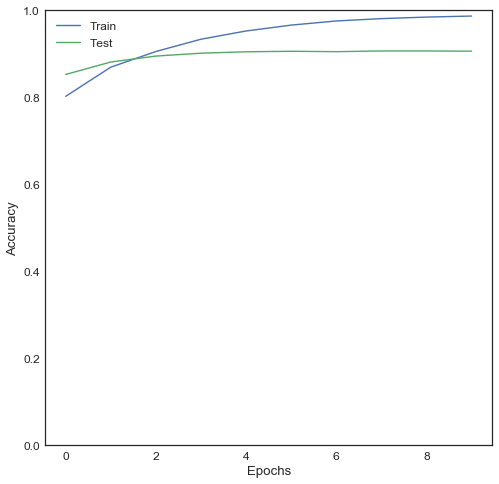

In [231]:
fig, ax = plt.subplots(figsize = (8, 8))
plot_learning_curve(dense_history, ax)

In [222]:
stack_train_pred = stack_dense.predict(stack_X_train)
stack_test_pred = stack_dense.predict(stack_X_test)

In [224]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_train, stack_train_pred, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.9998996847234165
Fully-connected Exact Accuracy on train : 0.998280309544282
Fully-connected Precision on train : 0.9999732477260567
Fully-connected Recall on train : 0.9989564163075706
Fully-connected Hit Rate on train : 1.0
Fully-connected F1 score on train : 0.9994645733918726


In [225]:
# evaluation
print('Fully-connected Avg Accuracy on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'avg')))
print('Fully-connected Exact Accuracy on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'exact')))
print('Fully-connected Precision on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'precision')))
print('Fully-connected Recall on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'recall')))
print('Fully-connected Hit Rate on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'hit')))
print('Fully-connected F1 score on train : {}'.format(score_thres(y_test, stack_test_pred, method = 'f1')))

Fully-connected Avg Accuracy on train : 0.9050973654066438
Fully-connected Exact Accuracy on train : 0.14891179839633448
Fully-connected Precision on train : 0.795204487961708
Fully-connected Recall on train : 0.5168061567721981
Fully-connected Hit Rate on train : 0.9484536082474226
Fully-connected F1 score on train : 0.6264683551479014


In [228]:
### save the stacked model
stack_dense.save('stack.h5')

In [236]:
stack_metrics = metrics_thres_df(y_train, y_test, stack_train_pred, stack_test_pred)

### Plot

In [289]:
score_df = pd.DataFrame({'Object Vectorization': obj_metrics,
                         'Stack Neural Network': stack_metrics
                        })

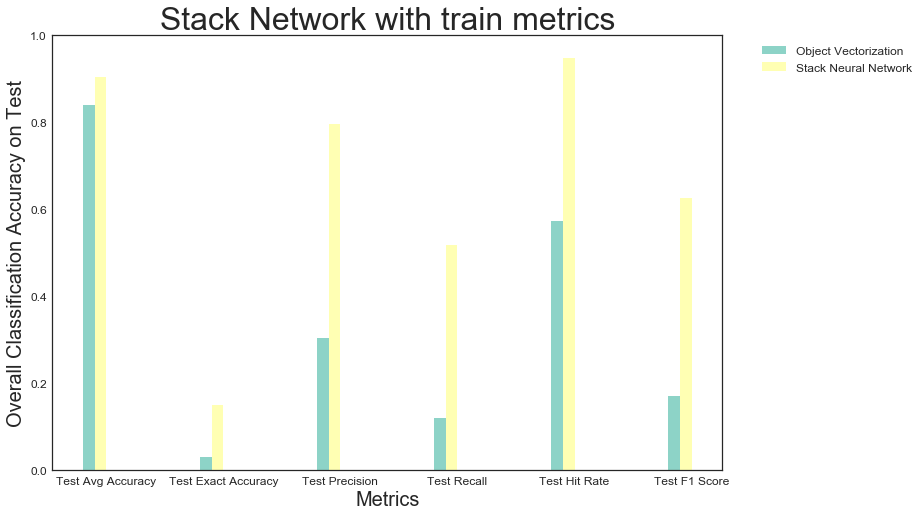

In [293]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for idx,col in enumerate(score_df.columns):
    plt.bar(np.arange(len(score_df.index[:6]))+idx*bar_width, score_df[[col]].values[6:12], 
            bar_width, color=sns.color_palette("Set3")[idx], label=col)
plt.xticks(np.arange(len(score_df.index[6:12]))+0.15, score_df.index[6:12])
plt.ylabel('Overall Classification Accuracy on Test', fontsize = 20)
plt.xlabel('Metrics', fontsize = 20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('Stack Network with train metrics', fontsize = 32)
plt.show()

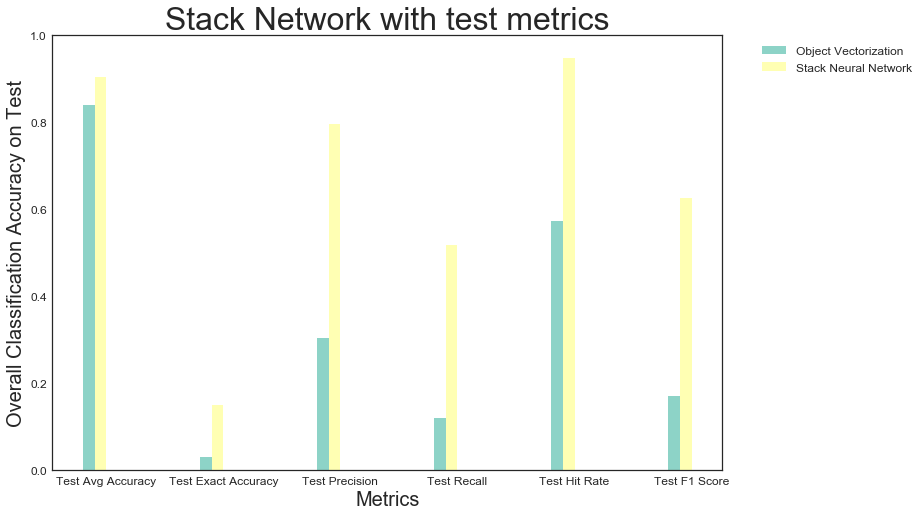

In [294]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for idx,col in enumerate(score_df.columns):
    plt.bar(np.arange(len(score_df.index[6:12]))+idx*bar_width, score_df[[col]].values[6:12], 
            bar_width, color=sns.color_palette("Set3")[idx], label=col)
plt.xticks(np.arange(len(score_df.index[6:12]))+0.15, score_df.index[6:12])
plt.ylabel('Overall Classification Accuracy on Test', fontsize = 20)
plt.xlabel('Metrics', fontsize = 20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('Stack Network with test metrics', fontsize = 32)
plt.show()

In [288]:
score_df

,Object Vectorization,Stack Predictor
Train Avg Accuracy,0.876598,0.999900
Train Exact Accuracy,0.091717,0.998280
Train Precision,0.844692,0.999973
Train Recall,0.231267,0.998956
Train Hit Rate,0.702494,1.000000
Train F1 Score,0.363117,0.999465
Test Avg Accuracy,0.838946,0.905097
Test Exact Accuracy,0.029782,0.148912
Test Precision,0.304179,0.795204
Test Recall,0.119084,0.516806


Genre sport: 24 correct out of 42
Genre music: 19 correct out of 43
Genre biography: 17 correct out of 80
Genre animation: 19 correct out of 62
Genre history: 14 correct out of 56
Genre war: 42 correct out of 69
Genre western: 25 correct out of 43
Genre musical: 9 correct out of 57
Genre sci_fi: 78 correct out of 120
Genre fantasy: 67 correct out of 128
Genre family: 69 correct out of 125
Genre mystery: 29 correct out of 89
Genre adventure: 136 correct out of 230
Genre horror: 48 correct out of 89
Genre crime: 87 correct out of 156
Genre thriller: 164 correct out of 254
Genre action: 161 correct out of 233
Genre romance: 123 correct out of 197
Genre comedy: 205 correct out of 302
Genre drama: 381 correct out of 461


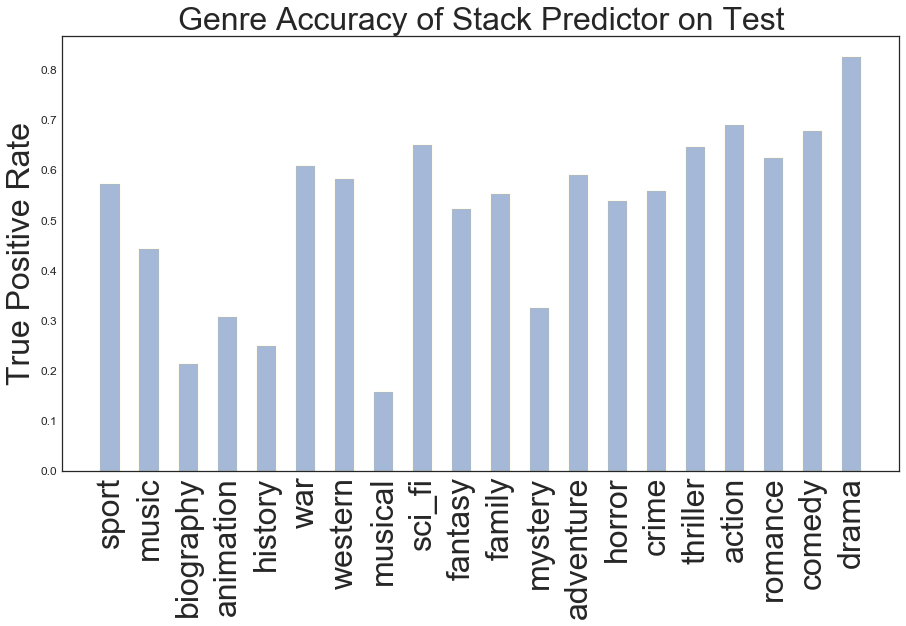

In [246]:
genre_acc(y_test, stack_test_pred, genre_dict, 'Genre Accuracy of Stack Predictor on Test', is_neural_net = True)

### Precision-recall curve on neural network

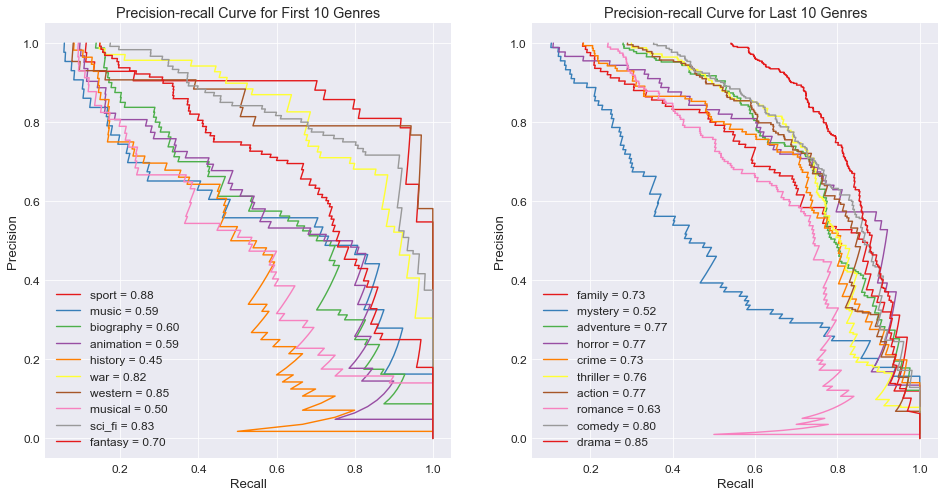

In [287]:
plot_precision_recall(y_test, stack_test_pred, genre_dict)